In [2]:
import numpy as np
import pandas as pd
from scipy.signal import correlate
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import matplotlib
from itertools import product
from scipy.optimize import dual_annealing, minimize
import copy


In [12]:

df_eye_all = pd.read_csv('processed_data\processed_data_asc_task_anti_sacccades_all_post_process_indiv.csv')
df_cam_all = pd.read_csv('processed_data\processed_data_tiny_task_anti_sacccades_all_post_process_indiv.csv')


In [13]:
df_cam_all_006 = df_cam_all[df_cam_all['participants']=='P006']
df_eye_all_006 = df_eye_all[df_eye_all['participants']=='P006']

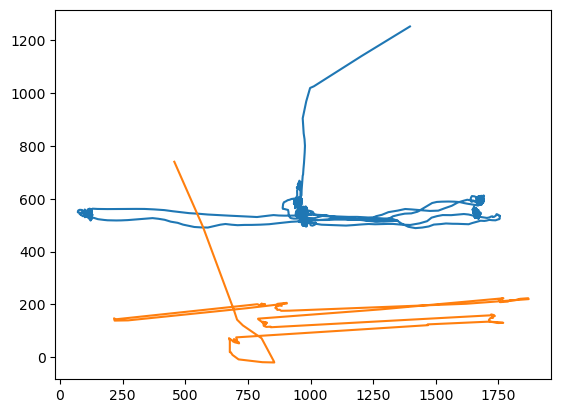

In [14]:
plt.plot(df_eye_all_006['RX_'][:8000],df_eye_all_006['RY_'][:8000])
plt.plot(df_cam_all_006['post_calX'][:200],df_cam_all_006['post_calY'][:200])

In [15]:
df_cam_all_006

,Time,calX,calY,rawX,rawY,participants,time_delay,X,Y,interval_num,eyelink_time,x_rol_median,y_rol_median,remapX,remapY,post_cal,post_calX,post_calY
0,1.741257e+09,675.78,-1136.85,324.29,177.27,P006,349/240,-0.65,0,1,50637366,323.750,178.830,324.342938,171.746750,"(456.69595396843823, 740.4264184041323)",456.695954,740.426418
1,1.741257e+09,591.18,-996.11,323.40,179.24,P006,349/240,-0.65,0,1,50637404,323.705,178.050,324.295683,171.436080,"(511.5224764536292, 622.1848053182453)",511.522476,622.184805
2,1.741257e+09,622.29,-1022.84,323.75,178.83,P006,349/240,-0.65,0,1,50637434,323.660,177.270,324.248428,171.125409,"(570.5428816110141, 494.92165650646507)",570.542882,494.921657
3,1.741257e+09,521.49,-1310.43,323.66,175.56,P006,349/240,-0.65,0,1,50637534,323.620,175.560,324.206423,170.444324,"(695.1375982300732, 176.7015967111799)",695.137598,176.701597
4,1.741257e+09,502.05,-1339.02,323.62,175.39,P006,349/240,-0.65,0,1,50637546,323.620,175.390,324.206423,170.376614,"(707.0863731680978, 142.25768791510848)",707.086373,142.257688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,1.741257e+09,178.97,-1143.04,321.66,175.81,P006,256/240,-0.65,0,10,50659538,321.700,175.810,322.190202,170.543898,"(1903.2713981484067, 381.77839506784045)",1903.271398,381.778395
555,1.741257e+09,180.68,-1147.77,321.70,175.79,P006,256/240,-0.65,0,10,50659563,321.660,175.810,322.148198,170.543898,"(1948.9125465207649, 387.5614630422005)",1948.912547,387.561463
556,1.741257e+09,173.60,-1138.85,321.62,175.83,P006,256/240,-0.65,0,10,50659602,321.640,175.820,322.127195,170.547881,"(1970.1446485768843, 393.9541091526673)",1970.144649,393.954109
557,1.741257e+09,176.69,-1140.92,321.64,175.82,P006,256/240,-0.65,0,10,50659634,321.630,175.825,322.116694,170.549872,"(1980.906806655318, 397.1971287967474)",1980.906807,397.197129


In [16]:


def find_optimal_transformation(X_tiny, X_eyelink, grid_size=100, scale_N=2, shift_N=3):
    """
    Find optimal scale and shift to transform X_tiny to match X_eyelink using dual annealing
    followed by gradient descent fine-tuning. Warns if optimal values are at boundaries.
    Handles positive and negative mean_diff for shift_range.
    
    Parameters:
    X_tiny: numpy array, input data to be transformed
    X_eyelink: numpy array, target data
    grid_size: int, number of points for range definition (used for bounds)
    scale_N: float, multiplier for scale range
    shift_N: float, multiplier for shift range
    
    Returns:
    best_scale, best_shift: optimal transformation parameters
    """
    
    # Define ranges for bounds
    scale_range = np.linspace(np.std(X_eyelink)/(scale_N*np.std(X_tiny)),
                             scale_N*np.std(X_eyelink)/np.std(X_tiny), grid_size)
    
    reverse_scaling = np.std(X_tiny)/np.std(X_eyelink)
    mean_diff = np.mean(X_eyelink) - np.mean(X_tiny)/reverse_scaling
    
    print(f"Reverse scaling: {reverse_scaling:.4f}")
    print(f"Mean difference: {mean_diff:.4f}")
    
    # Define shift_range, handling positive and negative mean_diff
    epsilon = 1e-6
    if mean_diff == 0:
        shift_range = np.linspace(-epsilon, epsilon, grid_size)
    else:
        center = reverse_scaling * mean_diff
        width = reverse_scaling * abs(mean_diff) * shift_N
        shift_range = np.linspace(center - width, center + width, grid_size)

    # Define bounds for dual annealing
    bounds = [(scale_range[0], scale_range[-1]), (shift_range[0], shift_range[-1])]
    
    # Objective function: MSE between transformed X_tiny and X_eyelink
    def objective(params):
        scale, shift = params
        transformed = scale * (X_tiny + shift)
        return np.mean((transformed - X_eyelink) ** 2)
    
    # Run dual annealing
    result = dual_annealing(objective, bounds, seed=42)
    best_scale, best_shift = result.x
    
    # Check if optimal values are at boundaries
    if np.isclose(best_scale, scale_range[0]) or np.isclose(best_scale, scale_range[-1]):
        print(f"Warning: Optimal scale ({best_scale:.4f}) is at the boundary of the grid "
              f"(range: [{scale_range[0]:.4f}, {scale_range[-1]:.4f}]). "
              "Consider increasing the scale_N or grid_size.")
    if np.isclose(best_shift, shift_range[0]) or np.isclose(best_shift, shift_range[-1]):
        print(f"Warning: Optimal shift ({best_shift:.4f}) is at the boundary of the grid "
              f"(range: [{shift_range[0]:.4f}, {shift_range[-1]:.4f}]). "
              "Consider increasing the shift_N or grid_size.")
    
    # Gradient descent fine-tuning using BFGS
    result = minimize(objective, x0=[best_scale, best_shift], method='BFGS')
    best_scale, best_shift = result.x
    
    return best_scale, best_shift



PID P006 → global lag = 88.0 ms
Reverse scaling: 1.0765
Mean difference: 74.2810
Participant; P006, Optimal scale: 0.8757, Optimal shift: 140.6851
PID P008 → global lag = 106.0 ms
Reverse scaling: 0.4934
Mean difference: -1518.7940
Participant; P008, Optimal scale: 1.9071, Optimal shift: -716.0250
PID P020 → global lag = 63.0 ms
Reverse scaling: 1.3171
Mean difference: 359.9833
Participant; P020, Optimal scale: 0.7460, Optimal shift: 495.8096
PID P036 → global lag = 74.0 ms
Reverse scaling: 1.2804
Mean difference: 206.5401
Participant; P036, Optimal scale: 0.7668, Optimal shift: 284.0660
PID P063 → global lag = 51.0 ms
Reverse scaling: 1.2037
Mean difference: 109.3606
Participant; P063, Optimal scale: 0.8079, Optimal shift: 165.6232
PID P065 → global lag = 0.0 ms
Reverse scaling: 0.0000
Mean difference: -1325807887822562816.0000
Participant; P065, Optimal scale: 714602940708251.0000, Optimal shift: -1969.9804
PID P070 → global lag = 79.0 ms
Reverse scaling: 1.1544
Mean difference: 238.

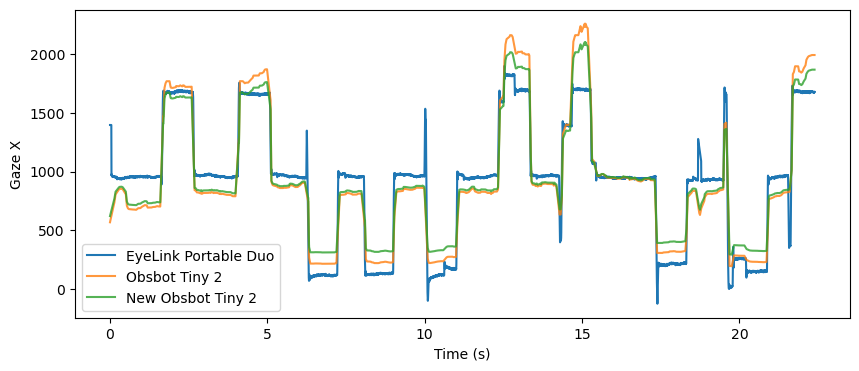

In [17]:


df_eye_all.rename(columns={'Time': 'time', 'RX_': 'x', 'RY_': 'y', 'participants': 'participant'}, inplace=True)
df_cam_all.rename(columns={'eyelink_time': 'time', 'post_calX': 'x', 'participants': 'participant'}, inplace=True)

# compute each participant’s eye‐start and subtract from both streams
df_eye_all['t0_ms'] = df_eye_all.groupby('participant')['time'].transform('first')
df_eye_all['t_ms0'] = df_eye_all['time'] - df_eye_all['t0_ms']

t0_df = df_eye_all[['participant','t0_ms']].drop_duplicates()
df_cam_all = df_cam_all.merge(t0_df, on='participant', how='left')
df_cam_all['t_ms0'] = df_cam_all['time'] - df_cam_all['t0_ms']


# CLEAN + GLOBAL‐LAG FUNCTION (ms)
def clean_and_estimate_global_lag_ms(eye_df, cam_df,
                                     max_interp_gap_ms=300,
                                     max_search_ms=500):
    # eye time grid & sampling interval
    t_eye = eye_df['t_ms0'].values
    dt = np.median(np.diff(t_eye))                 
    # max_gap_samps = max(1, int(max_interp_gap_ms / dt))

    df = eye_df.copy()
    df['x_imputed'] = df['x'].interpolate(
        method='linear',  limit_direction='both'
    )
    good = np.isfinite(df['x_imputed'])
    df['good_mask'] = good

    #  raw start‐time offset (ms)
    raw_offset = cam_df['t_ms0'].iloc[0] - eye_df['t_ms0'].iloc[0]
    t_cam_aligned = cam_df['t_ms0'].values - raw_offset

    # interpolate cam.x onto the eye time grid
    x_cam_on_t = np.interp(t_eye, t_cam_aligned, cam_df['x'].values)

    # Build a mask of valid (finite) samples in both streams
    good_eye = np.isfinite(eye_df['x'].values)
    good_cam = np.isfinite(x_cam_on_t)
    good     = good_eye & good_cam
    if good.sum() < 2:
        raise ValueError("Not enough overlapping valid samples to estimate lag.")

    # Cross-correlate over only the “good” points, restricted to ±max_search_ms
    xr = eye_df['x'].values[good]
    xc = x_cam_on_t[good]
    xr = xr - xr.mean()
    xc = xc - xc.mean()

    cc    = correlate(xc, xr, mode='full', method='direct')
    lags  = np.arange(-len(xc)+1, len(xr))
    max_p = int(max_search_ms / dt)
    valid = np.abs(lags) <= max_p

    best   = lags[valid][np.argmax(cc[valid])]
    lag_ms = best * dt
    return df, lag_ms


# LOCAL‐WARP FUNCTION (seconds)
def align_by_local_correlation(t_ref, x_ref, t_cam, x_cam,
                               window_sec=2.0, step_sec=0.5,
                               max_lag_sec=0.5, smooth_spline_s=1e-2,
                               spline_k=3, min_samples_per_win=10):
    """
    Time‐warp camera timestamps to match reference.
    """
    # sliding‐window centers
    t0, t1 = t_ref[0], t_ref[-1]
    centers = np.arange(t0 + window_sec/2,
                        t1 - window_sec/2 + 1e-8,
                        step_sec)
    center_list, lag_list = [], []

    for tc in centers:
        w0, w1 = tc - window_sec/2, tc + window_sec/2
        mask_ref = (t_ref>=w0)&(t_ref<=w1)
        mask_cam = (t_cam>=w0-max_lag_sec)&(t_cam<=w1+max_lag_sec)

        xr = x_ref[mask_ref]; tr = t_ref[mask_ref]
        xc = x_cam[mask_cam]; tc_sub = t_cam[mask_cam]
        if len(xr)<min_samples_per_win or len(xc)<min_samples_per_win:
            continue

        N = max(len(xr), len(xc), 200)
        uni_t = np.linspace(w0, w1, N)
        xr_u = np.interp(uni_t, tr, xr)
        xc_u = np.interp(uni_t, tc_sub, xc)

        max_pts = int(max_lag_sec / (uni_t[1]-uni_t[0]))
        cc = correlate(xc_u - xc_u.mean(),
                       xr_u - xr_u.mean(),
                       mode='full')
        lags_pts = np.arange(-len(xc_u)+1, len(xr_u))
        valid = np.abs(lags_pts) <= max_pts
        lags_sub, cc_sub = lags_pts[valid], cc[valid]
        best = lags_sub[np.argmax(cc_sub)]
        lag_sec = best * (uni_t[1]-uni_t[0])

        center_list.append(tc)
        lag_list.append(lag_sec)

    centers = np.array(center_list); lags = np.array(lag_list)
    if len(lags) <= 1:
        const = float(lags[0]) if len(lags)==1 else 0.0
        lag_fn = lambda t: const
    else:
        k_fit = min(spline_k, len(lags)-1)
        lag_fn = UnivariateSpline(centers, lags, k=k_fit, s=smooth_spline_s)

    t_cam_corr = t_cam - lag_fn(t_cam)
    return t_cam_corr, lag_fn



aligned_results = []

# per participant
for pid in df_eye_all['participant'].unique():
    eye = df_eye_all[df_eye_all.participant==pid].reset_index(drop=True)
    cam = df_cam_all[df_cam_all.participant==pid].reset_index(drop=True)
    if cam.empty:
        print(f"PID {pid}: no camera data, skipping.")
        continue

    # clean + compute refined global lag (ms)
    eye_clean, lag_ms = clean_and_estimate_global_lag_ms(eye, cam)
    print(f"PID {pid} → global lag = {lag_ms:.1f} ms")

    # apply constant shift & convert to seconds
    cam['t_shifted_s'] = (cam['t_ms0'] - lag_ms) / 1000.0
    t_ref = eye_clean['t_ms0'].values / 1000.0
    x_ref = eye_clean['x_imputed'].values
    t_cam = cam['t_shifted_s'].values
    x_cam = cam['x'].values

    # fine align using local correlation
    t_cam_corr, lag_fn = align_by_local_correlation(
        t_ref, x_ref, t_cam, x_cam,
        window_sec=1.8, step_sec=0.5, max_lag_sec=0.5, smooth_spline_s=1e-2
    )

    # interpolate tiny camera signals onto eyelink time grid
    eye_clean['x_cam_aligned'] = np.interp(t_ref, t_cam_corr, cam['x'].values)
    # eye_clean['y_cam_aligned'] = np.interp(t_ref, t_cam_corr, cam['y'].values)

    # use grid search to find the optimal scale and shift
    optimal_scale, optimal_shift = find_optimal_transformation(np.array(eye_clean['x_cam_aligned']), np.array(eye_clean['x_imputed']) ,grid_size=100, scale_N=2, shift_N=5)
    print(f"Participant; {pid}, Optimal scale: {optimal_scale:.4f}, Optimal shift: {optimal_shift:.4f}")
    
    # apply the optimal scale and shift to tiny data
    eye_clean['new_tinyX'] = optimal_scale * (np.array(eye_clean['x_cam_aligned'].values) + optimal_shift)

    aligned_results.append({
        'participant': pid,
        'eye_aligned_df': eye_clean,
        'cam_aligned_df': cam.assign(t_cam_corr_s=t_cam_corr),
        'global_lag_ms': lag_ms,
        'lag_fn': lag_fn
    })

all_aligned = pd.concat(
    [res['eye_aligned_df'] for res in aligned_results],
    ignore_index=True
)

res0 = aligned_results[0]
eye0 = res0['eye_aligned_df']
plt.figure(figsize=(10,4))
plt.plot(eye0['t_ms0']/1000.0, eye0['x_imputed'],      label='EyeLink Portable Duo')
plt.plot(eye0['t_ms0']/1000.0, eye0['x_cam_aligned'], label='Obsbot Tiny 2', alpha=0.8)
plt.plot(eye0['t_ms0']/1000.0, eye0['new_tinyX'], label='New Obsbot Tiny 2', alpha=0.8)
plt.xlabel('Time (s)'); plt.ylabel('Gaze X'); plt.legend(); plt.show()


In [19]:
# eleminating participant P065 at index 5
# del aligned_results[5]

In [20]:
task_data_df = []
for i in range(len(aligned_results)):
    for data in aligned_results[i]['eye_aligned_df'].groupby('interval_num'):
        task_data_df.append(data[1])

In [64]:
task_data_df[0]

,time,RX,RY,state,participant,time_delay,X,Y,interval_num,x,y,t0_ms,t_ms0,x_imputed,good_mask,x_cam_aligned,new_tinyX
0,50637353.0,NaN,NaN,0.0,P006,1.45,-0.65,0,1,1396.7,1252.8,50637353.0,0.0,1396.7,True,569.475056,621.870470
1,50637354.0,NaN,NaN,0.0,P006,1.45,-0.65,0,1,1396.7,1252.8,50637353.0,1.0,1396.7,True,571.119894,623.310815
2,50637355.0,NaN,NaN,0.0,P006,1.45,-0.65,0,1,1396.7,1252.8,50637353.0,2.0,1396.7,True,572.373097,624.408215
3,50637356.0,NaN,NaN,0.0,P006,1.45,-0.65,0,1,1396.7,1252.8,50637353.0,3.0,1396.7,True,573.626300,625.505615
4,50637357.0,NaN,NaN,0.0,P006,1.45,-0.65,0,1,1396.7,1252.8,50637353.0,4.0,1396.7,True,574.879502,626.603015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2452,50639805.0,1679.5,599.9,1.0,P006,1.45,-0.65,0,1,1679.5,599.9,50637353.0,2452.0,1679.5,True,1720.657270,1629.933602
2453,50639806.0,1681.8,601.1,1.0,P006,1.45,-0.65,0,1,1681.8,601.1,50637353.0,2453.0,1681.8,True,1720.657270,1629.933602
2454,50639807.0,1682.5,602.1,1.0,P006,1.45,-0.65,0,1,1682.5,602.1,50637353.0,2454.0,1682.5,True,1720.657270,1629.933602
2455,50639808.0,1683.5,600.8,1.0,P006,1.45,-0.65,0,1,1683.5,600.8,50637353.0,2455.0,1683.5,True,1720.657270,1629.933602


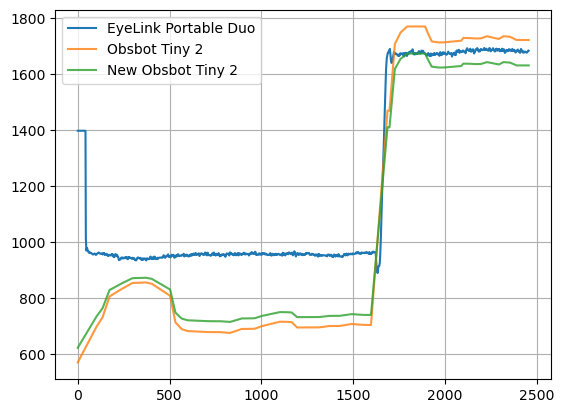

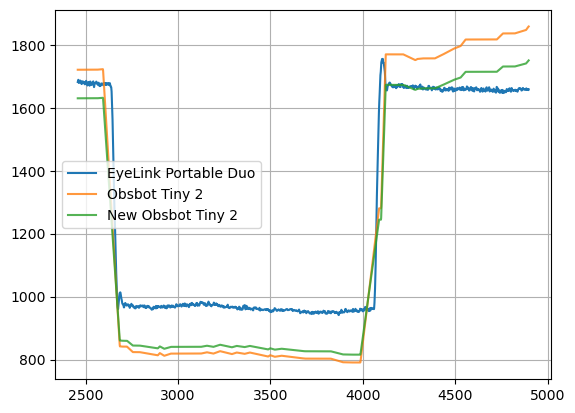

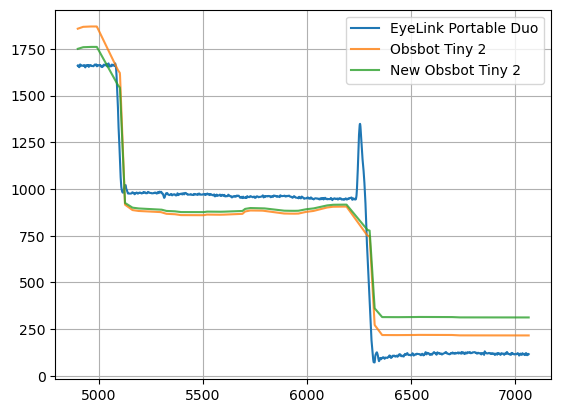

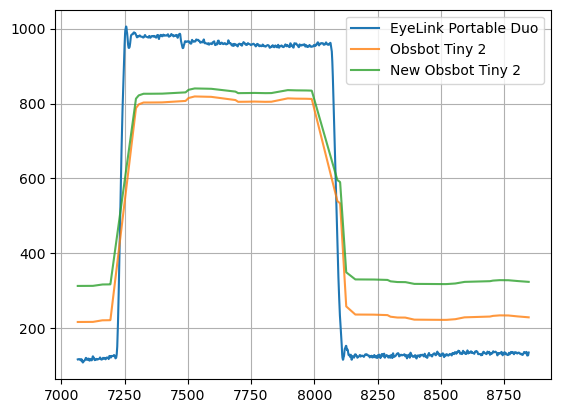

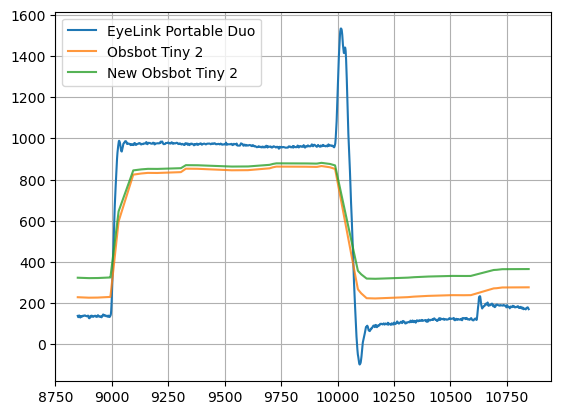

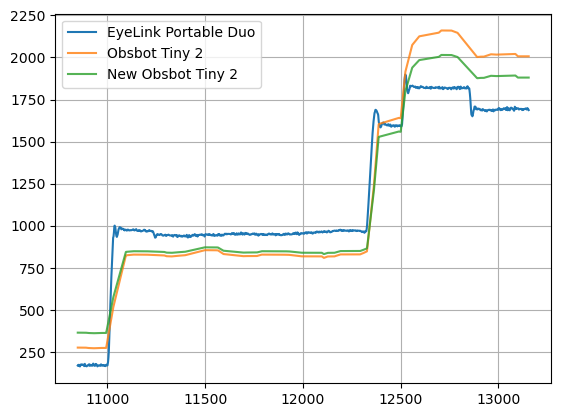

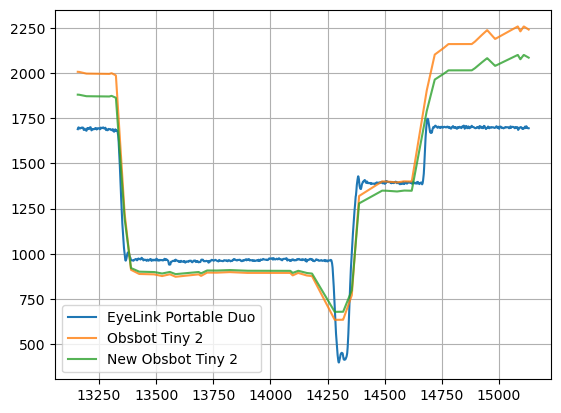

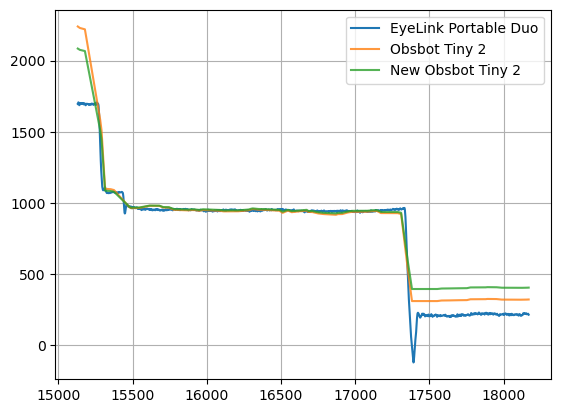

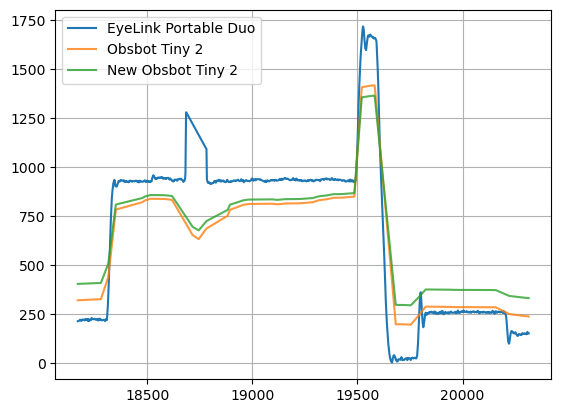

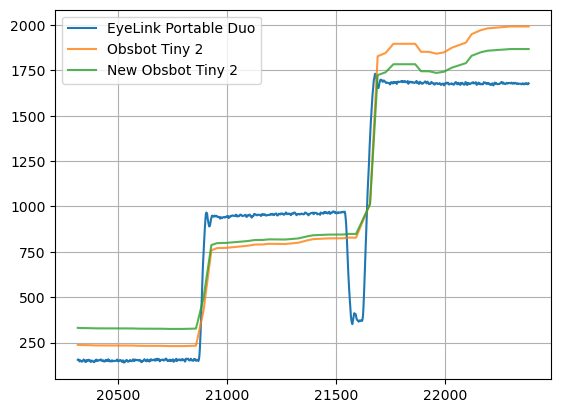

In [22]:
for i in range(10):
    plt.plot(task_data_df[i]['t_ms0'], task_data_df[i]['x_imputed'], label='EyeLink Portable Duo')
    plt.plot(task_data_df[i]['t_ms0'], task_data_df[i]['x_cam_aligned'], label='Obsbot Tiny 2', alpha=0.8)
    plt.plot(task_data_df[i]['t_ms0'], task_data_df[i]['new_tinyX'], label='New Obsbot Tiny 2', alpha=0.8)
    plt.grid(True)
    plt.legend()
    plt.show()

In [24]:
len(task_data_df[0])

2457

In [25]:
task_data_df[0].t_ms0.max() - task_data_df[0].t_ms0.min()

2456.0

In [26]:
task_data_df[0].get(1,'time_delay')

'time_delay'

In [27]:
# task_data_df[data].t_ms0.max() - task_data_df[data].t_ms0.min()

In [28]:
# predicted_time_saccade = [(float(task_data_df[data].time_delay[0])+1)*1000 for data in range(len(task_data_df))]

In [29]:
# actual_time_saccade = [len(task_data_df[data]) for data in range(len(task_data_df))]

In [30]:
# np.sum(predicted_time_saccade) / np.sum(actual_time_saccade)


In [31]:
# predicted_time_saccade[0]

In [32]:
# actual_time_saccade[0]

In [33]:
# diff_saccade = np.array(predicted_time_saccade) - np.array(actual_time_saccade)

In [34]:
# plt.plot(diff_saccade,'.')
# plt.plot(diff_saccade)

In [35]:
# indices_saccade = np.where(~(diff_saccade < 300))[0]
# indices_saccade = np.where(~((diff_saccade < 300) & (diff_saccade > 200)))[0]
# indices_saccade

In [36]:
# indices_to_remove_saccade = list(set(indices_saccade.tolist()))
# indices_to_remove_saccade.sort(reverse=True)

In [37]:
test_data_df = copy.deepcopy(task_data_df) 


In [38]:
# for index in indices_to_remove_saccade:
#     if 0 <= index < len(test_data_df):
#         test_data_df.pop(index)

In [39]:
test_data_df[0]

,time,RX,RY,state,participant,time_delay,X,Y,interval_num,x,y,t0_ms,t_ms0,x_imputed,good_mask,x_cam_aligned,new_tinyX
0,50637353.0,NaN,NaN,0.0,P006,1.45,-0.65,0,1,1396.7,1252.8,50637353.0,0.0,1396.7,True,569.475056,621.870470
1,50637354.0,NaN,NaN,0.0,P006,1.45,-0.65,0,1,1396.7,1252.8,50637353.0,1.0,1396.7,True,571.119894,623.310815
2,50637355.0,NaN,NaN,0.0,P006,1.45,-0.65,0,1,1396.7,1252.8,50637353.0,2.0,1396.7,True,572.373097,624.408215
3,50637356.0,NaN,NaN,0.0,P006,1.45,-0.65,0,1,1396.7,1252.8,50637353.0,3.0,1396.7,True,573.626300,625.505615
4,50637357.0,NaN,NaN,0.0,P006,1.45,-0.65,0,1,1396.7,1252.8,50637353.0,4.0,1396.7,True,574.879502,626.603015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2452,50639805.0,1679.5,599.9,1.0,P006,1.45,-0.65,0,1,1679.5,599.9,50637353.0,2452.0,1679.5,True,1720.657270,1629.933602
2453,50639806.0,1681.8,601.1,1.0,P006,1.45,-0.65,0,1,1681.8,601.1,50637353.0,2453.0,1681.8,True,1720.657270,1629.933602
2454,50639807.0,1682.5,602.1,1.0,P006,1.45,-0.65,0,1,1682.5,602.1,50637353.0,2454.0,1682.5,True,1720.657270,1629.933602
2455,50639808.0,1683.5,600.8,1.0,P006,1.45,-0.65,0,1,1683.5,600.8,50637353.0,2455.0,1683.5,True,1720.657270,1629.933602


6673.0 1230.0 1230 1.23 -0.65


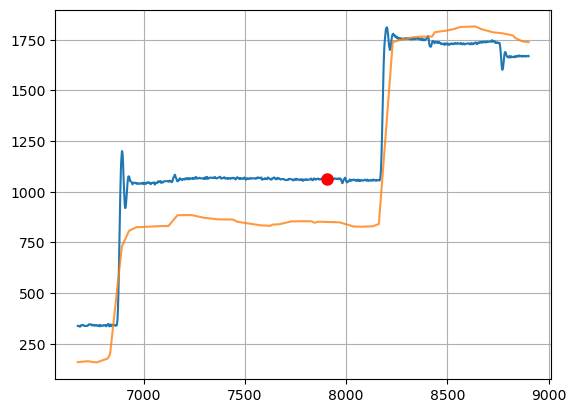

In [40]:
ind = 63
task_data_df[ind] = task_data_df[ind].reset_index(drop=True)
# starting_time = task_data_df[ind]['time'].min()
starting_time = task_data_df[ind]['t_ms0'].min()
time_offset_ms = float(task_data_df[ind].time_delay[0]) * 1000  # Convert seconds to milliseconds
index_to_highlight = (task_data_df[ind]['t_ms0'] - starting_time - time_offset_ms).abs().idxmin()
i0 = index_to_highlight

print(starting_time,time_offset_ms, index_to_highlight, task_data_df[ind].time_delay[0], task_data_df[ind].X[0])
plt.plot(task_data_df[ind]['t_ms0'], task_data_df[ind]['x_imputed'], label='Eye Tracker')
plt.plot(task_data_df[ind]['t_ms0'], task_data_df[ind]['x_cam_aligned'], label='Camera Aligned', alpha=0.8)
plt.plot(task_data_df[ind]['t_ms0'][i0], task_data_df[ind]['x_imputed'][i0], marker='o', color='red', markersize=8, label=f'idx {i0}')
plt.grid(True)
plt.show()

In [ ]:
reaction_time_saccade_asc = []
reaction_time_saccade_tiny = []
countnan = 0
looked_at_asc = {'Correct':0, 'Second_Correct':0, 'Incorrect':0}
looked_at_tiny = {'Correct':0, 'Second_Correct':0, 'Incorrect':0}

looked_at_asc1 = []
looked_at_tiny1= []

for i in range(len(test_data_df)):
    # if i == 3:
    test_data_df[i] = test_data_df[i].reset_index(drop=True)
    starting_time = test_data_df[i]['t_ms0'].min()
    time_offset_ms = float(test_data_df[i].time_delay[0]) * 1000  # Convert seconds to milliseconds
    position = test_data_df[i].X[0]

    index_to_highlight = (test_data_df[i]['t_ms0'] - starting_time - time_offset_ms).abs().idxmin()

    saccade_start_saccade_asc_1 =np.append( np.where(test_data_df[i]['x_imputed'][index_to_highlight:] > 1344 )[0],10000)
    saccade_start_saccade_asc_2 = np.append( np.where(test_data_df[i]['x_imputed'][index_to_highlight:] < 576 )[0],10000)
    saccade_start_saccade_asc = np.min(np.hstack([saccade_start_saccade_asc_1,saccade_start_saccade_asc_2]))
    
    saccade_start_saccade_tiny_1 =np.append( np.where(test_data_df[i]['new_tinyX'][index_to_highlight:] > 1344 )[0],10000)
    saccade_start_saccade_tiny_2 = np.append( np.where(test_data_df[i]['new_tinyX'][index_to_highlight:] < 576 )[0],10000)
    saccade_start_saccade_tiny = np.min(np.hstack([saccade_start_saccade_tiny_1,saccade_start_saccade_tiny_2]))


    if saccade_start_saccade_asc_1[0] < saccade_start_saccade_asc_2[0]:
        if position == 0.65:
            looked_at_asc1.append([position, 1])
        else:
            looked_at_asc1.append([position, 0])
    else:
        if position == -0.65:
            looked_at_asc1.append([position, 1])
        else:
            looked_at_asc1.append([position, 0])
    
    if saccade_start_saccade_tiny_1[0] < saccade_start_saccade_tiny_2[0]:
        if position == 0.65:
            looked_at_tiny1.append([position, 1])
        else:
            looked_at_tiny1.append([position, 0])
    else:
        if position == -0.65:
            looked_at_tiny1.append([position, 1])
        else:
            looked_at_tiny1.append([position, 0])

In [75]:
s_looked_at_tiny1 = np.array(np.swapaxes(looked_at_tiny1,0,1)[1])
s_looked_at_asc1 = np.array(np.swapaxes(looked_at_asc1,0,1)[1])

In [76]:
np.sum(s_looked_at_asc1==s_looked_at_tiny1)/len(s_looked_at_asc1)


0.9512820512820512

In [ ]:
reaction_time_saccade_asc = []
reaction_time_saccade_tiny = []
countnan = 0
looked_at_asc = {'Correct':0, 'Second_Correct':0, 'Incorrect':0}
looked_at_tiny = {'Correct':0, 'Second_Correct':0, 'Incorrect':0}




for i in range(len(test_data_df)):
    # if i == 3:
    test_data_df[i] = test_data_df[i].reset_index(drop=True)
    starting_time = test_data_df[i]['t_ms0'].min()
    time_offset_ms = float(test_data_df[i].time_delay[0]) * 1000  # Convert seconds to milliseconds
    position = test_data_df[i].X[0]

    index_to_highlight = (test_data_df[i]['t_ms0'] - starting_time - time_offset_ms).abs().idxmin()

    saccade_start_saccade_asc_1 =np.append( np.where(test_data_df[i]['x_imputed'][index_to_highlight:] > 1344 )[0],10000)
    saccade_start_saccade_asc_2 = np.append( np.where(test_data_df[i]['x_imputed'][index_to_highlight:] < 576 )[0],10000)
    saccade_start_saccade_asc = np.min(np.hstack([saccade_start_saccade_asc_1,saccade_start_saccade_asc_2]))
    
    saccade_start_saccade_tiny_1 =np.append( np.where(test_data_df[i]['new_tinyX'][index_to_highlight:] > 1344 )[0],10000)
    saccade_start_saccade_tiny_2 = np.append( np.where(test_data_df[i]['new_tinyX'][index_to_highlight:] < 576 )[0],10000)
    saccade_start_saccade_tiny = np.min(np.hstack([saccade_start_saccade_tiny_1,saccade_start_saccade_tiny_2]))


    if position == 0.65:
        if saccade_start_saccade_asc_2[0] < saccade_start_saccade_asc_1[0]:
            looked_at_asc['Correct'] += 1 
            looked_at_asc1.append([position, 1])
            reaction_time_saccade_asc.append(saccade_start_saccade_asc_2[0])

        elif (saccade_start_saccade_asc_1[0] < saccade_start_saccade_asc_2[0]) and (saccade_start_saccade_asc_2[0] < 10000):
            looked_at_asc['Second_Correct'] += 1
            looked_at_asc1.append([position, 0])
            reaction_time_saccade_asc.append(saccade_start_saccade_asc_2[0])

        elif saccade_start_saccade_asc_2[0] == 10000:
            looked_at_asc['Incorrect'] += 1  
            looked_at_asc1.append([position, 0])
        else:
            pass

    if position == -0.65:
        if saccade_start_saccade_asc_1[0] < saccade_start_saccade_asc_2[0]:
            looked_at_asc['Correct'] += 1 
            looked_at_asc1.append([position, 1])
            reaction_time_saccade_asc.append(saccade_start_saccade_asc_1[0])

        elif (saccade_start_saccade_asc_2[0] < saccade_start_saccade_asc_1[0]) and (saccade_start_saccade_asc_1[0] < 10000):
            looked_at_asc['Second_Correct'] += 1
            looked_at_asc1.append([position, 0])
            reaction_time_saccade_asc.append(saccade_start_saccade_asc_1[0])

        elif saccade_start_saccade_asc_1[0] == 10000:
            looked_at_asc['Incorrect'] += 1 
            looked_at_asc1.append([position, 0])


    if position == 0.65:
        if saccade_start_saccade_tiny_2[0] < saccade_start_saccade_tiny_1[0]:
            looked_at_tiny['Correct'] += 1 
            looked_at_tiny1.append([position, 1])
            reaction_time_saccade_tiny.append(saccade_start_saccade_tiny_2[0])

        elif (saccade_start_saccade_tiny_1[0] < saccade_start_saccade_tiny_2[0]) and (saccade_start_saccade_tiny_2[0] < 10000):
            looked_at_tiny['Second_Correct'] += 1
            looked_at_tiny1.append([position, 0])
            reaction_time_saccade_tiny.append(saccade_start_saccade_tiny_2[0])

        elif saccade_start_saccade_tiny_2[0] == 10000:
            looked_at_tiny['Incorrect'] += 1 
            looked_at_tiny1.append([position, 0])
        else:
            pass

    if position == -0.65:
        if saccade_start_saccade_tiny_1[0] < saccade_start_saccade_tiny_2[0]:
            looked_at_tiny['Correct'] += 1 
            looked_at_tiny1.append([position, 1])
            reaction_time_saccade_tiny.append(saccade_start_saccade_tiny_1[0])

        elif (saccade_start_saccade_tiny_2[0] < saccade_start_saccade_tiny_1[0]) and (saccade_start_saccade_tiny_1[0] < 10000):
            looked_at_tiny['Second_Correct'] += 1
            looked_at_tiny1.append([position, 0])
            reaction_time_saccade_tiny.append(saccade_start_saccade_tiny_1[0])

        elif saccade_start_saccade_tiny_1[0] == 10000:
            looked_at_tiny['Incorrect'] += 1
            looked_at_tiny1.append([position, 0])
        else:
            pass 


In [78]:
s_looked_at_tiny1 = np.array(np.swapaxes(looked_at_tiny1,0,1)[1])
s_looked_at_asc1 = np.array(np.swapaxes(looked_at_asc1,0,1)[1])

In [79]:
np.sum(s_looked_at_asc1==s_looked_at_tiny1)/len(s_looked_at_asc1)


0.9512820512820512

In [51]:
looked_at_asc

{'Correct': 317, 'Second_Correct': 53, 'Incorrect': 20}

In [52]:
looked_at_tiny

{'Correct': 324, 'Second_Correct': 39, 'Incorrect': 27}

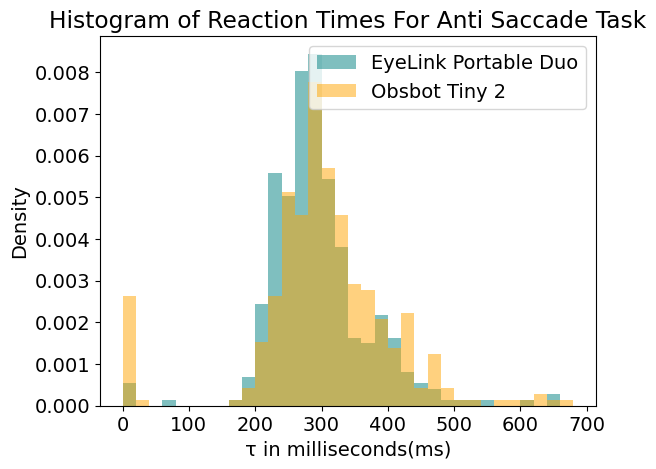

<Figure size 640x480 with 0 Axes>

In [53]:
matplotlib.rcParams.update({'font.size':14})

plt.hist(reaction_time_saccade_asc, np.arange(0,700,20), color='teal', density = True, alpha=0.5, label='EyeLink Portable Duo')
plt.hist(reaction_time_saccade_tiny, np.arange(0,700,20), color='orange', density = True, alpha=0.5, label='Obsbot Tiny 2')
plt.ylabel('Density')
plt.xlabel('\N{GREEK SMALL LETTER TAU} in milliseconds(ms)')
plt.title('Histogram of Reaction Times For Anti Saccade Task')
plt.legend()
plt.show()
plt.tight_layout()

In [54]:
len(reaction_time_saccade_asc)

370

In [55]:
reaction_time_saccade_tiny

[229,
 207,
 254,
 259,
 199,
 227,
 353,
 195,
 346,
 288,
 286,
 285,
 304,
 261,
 295,
 308,
 244,
 364,
 344,
 321,
 257,
 385,
 250,
 253,
 299,
 196,
 613,
 220,
 268,
 252,
 21,
 403,
 311,
 361,
 422,
 399,
 436,
 363,
 376,
 361,
 315,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 329,
 205,
 432,
 293,
 477,
 250,
 311,
 476,
 337,
 306,
 277,
 252,
 330,
 263,
 327,
 345,
 256,
 349,
 279,
 289,
 330,
 245,
 326,
 247,
 231,
 300,
 264,
 329,
 411,
 279,
 818,
 284,
 245,
 288,
 299,
 264,
 165,
 232,
 269,
 307,
 307,
 351,
 310,
 323,
 352,
 322,
 321,
 356,
 633,
 310,
 380,
 386,
 465,
 247,
 383,
 359,
 258,
 393,
 745,
 270,
 375,
 287,
 368,
 344,
 310,
 286,
 275,
 266,
 312,
 362,
 375,
 365,
 318,
 310,
 326,
 281,
 282,
 393,
 342,
 282,
 0,
 228,
 239,
 240,
 214,
 203,
 211,
 288,
 290,
 229,
 242,
 211,
 289,
 323,
 264,
 387,
 405,
 240,
 234,
 219,
 312,
 242,
 0,
 321,
 210,
 303,
 0,
 253,
 272,
 251,
 379,
 289,
 335,
 308,
 326,
 286,
 299,
 311,
 262,
 309,
 318,
 30

In [56]:
len(reaction_time_saccade_tiny)

363

In [57]:
with open('./Plots and Files/anti_saccade_task/reaction_time_anti_saccade_eyelink.txt', 'w') as f:
    f.writelines(f"{rt}\n" for rt in reaction_time_saccade_asc)

with open('./Plots and Files/anti_saccade_task/reaction_time_anti_saccade_tiny.txt', 'w') as f:
    f.writelines(f"{rt}\n" for rt in reaction_time_saccade_tiny)

In [3]:
looked_at_asc = {'Correct': 317, 'Error with correction': 53, 'Error without correction': 20}
looked_at_tiny = {'Correct': 324, 'Error with correction': 39, 'Error without correction': 27}

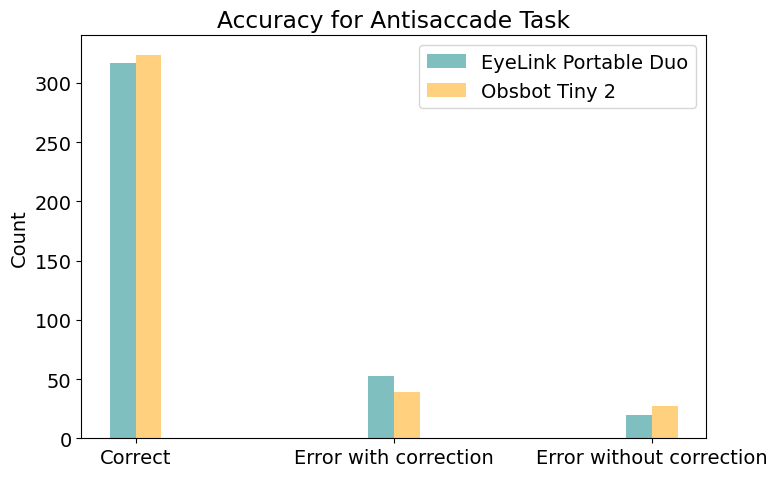

In [18]:
matplotlib.rcParams.update({'font.size':14})

# Get shared keys and their values
labels = list(looked_at_asc.keys())
values1 = [looked_at_asc[k] for k in labels]
values2 = [looked_at_tiny[k] for k in labels]

x = np.arange(len(labels))  # label locations
width = 0.1  # width of bars

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x - width/2, values1, width, color='teal', alpha=0.5, label='EyeLink Portable Duo')
ax.bar(x + width/2, values2, width, color='orange', alpha=0.5, label='Obsbot Tiny 2')

ax.set_ylabel('Count')
ax.set_title('Accuracy for Antisaccade Task')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

In [59]:
reaction_time_saccade_asc

[217,
 180,
 235,
 240,
 216,
 200,
 249,
 190,
 317,
 270,
 296,
 283,
 275,
 262,
 260,
 286,
 226,
 362,
 336,
 333,
 244,
 331,
 234,
 228,
 279,
 203,
 348,
 222,
 260,
 228,
 6,
 353,
 275,
 324,
 366,
 394,
 386,
 324,
 319,
 327,
 284,
 327,
 330,
 261,
 258,
 443,
 410,
 254,
 336,
 292,
 342,
 271,
 204,
 427,
 276,
 279,
 230,
 263,
 458,
 318,
 308,
 272,
 233,
 317,
 248,
 304,
 329,
 255,
 340,
 270,
 262,
 308,
 247,
 296,
 219,
 202,
 265,
 240,
 291,
 406,
 233,
 790,
 262,
 226,
 278,
 284,
 238,
 164,
 238,
 245,
 293,
 276,
 310,
 287,
 283,
 325,
 282,
 271,
 315,
 656,
 284,
 345,
 371,
 467,
 226,
 381,
 346,
 250,
 380,
 754,
 239,
 382,
 294,
 335,
 314,
 313,
 284,
 229,
 244,
 304,
 345,
 356,
 324,
 291,
 300,
 309,
 266,
 263,
 333,
 307,
 249,
 0,
 219,
 233,
 234,
 219,
 193,
 214,
 262,
 276,
 220,
 229,
 208,
 261,
 287,
 232,
 385,
 279,
 217,
 208,
 196,
 310,
 244,
 0,
 298,
 241,
 281,
 0,
 249,
 285,
 290,
 382,
 270,
 298,
 287,
 301,
 262,
 284,


In [60]:
reaction_time_saccade_tiny

[229,
 207,
 254,
 259,
 199,
 227,
 353,
 195,
 346,
 288,
 286,
 285,
 304,
 261,
 295,
 308,
 244,
 364,
 344,
 321,
 257,
 385,
 250,
 253,
 299,
 196,
 613,
 220,
 268,
 252,
 21,
 403,
 311,
 361,
 422,
 399,
 436,
 363,
 376,
 361,
 315,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 329,
 205,
 432,
 293,
 477,
 250,
 311,
 476,
 337,
 306,
 277,
 252,
 330,
 263,
 327,
 345,
 256,
 349,
 279,
 289,
 330,
 245,
 326,
 247,
 231,
 300,
 264,
 329,
 411,
 279,
 818,
 284,
 245,
 288,
 299,
 264,
 165,
 232,
 269,
 307,
 307,
 351,
 310,
 323,
 352,
 322,
 321,
 356,
 633,
 310,
 380,
 386,
 465,
 247,
 383,
 359,
 258,
 393,
 745,
 270,
 375,
 287,
 368,
 344,
 310,
 286,
 275,
 266,
 312,
 362,
 375,
 365,
 318,
 310,
 326,
 281,
 282,
 393,
 342,
 282,
 0,
 228,
 239,
 240,
 214,
 203,
 211,
 288,
 290,
 229,
 242,
 211,
 289,
 323,
 264,
 387,
 405,
 240,
 234,
 219,
 312,
 242,
 0,
 321,
 210,
 303,
 0,
 253,
 272,
 251,
 379,
 289,
 335,
 308,
 326,
 286,
 299,
 311,
 262,
 309,
 318,
 30

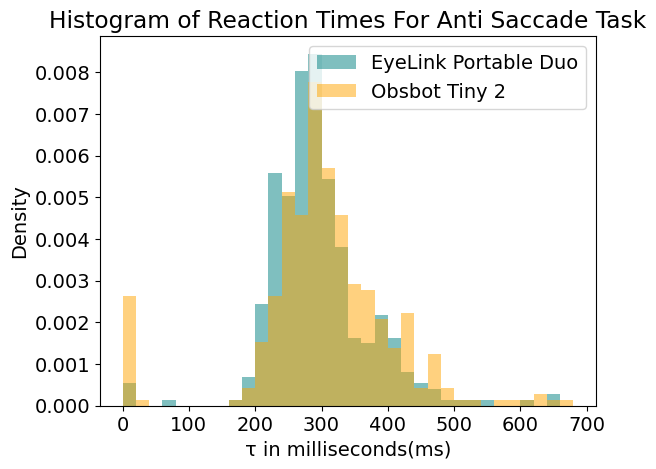

<Figure size 640x480 with 0 Axes>

In [61]:
matplotlib.rcParams.update({'font.size':14})

plt.hist(reaction_time_saccade_asc, np.arange(0,700,20), color='teal', density = True, alpha=0.5, label='EyeLink Portable Duo')
plt.hist(reaction_time_saccade_tiny, np.arange(0,700,20), color='orange', density = True, alpha=0.5, label='Obsbot Tiny 2')
plt.ylabel('Density')
plt.xlabel('\N{GREEK SMALL LETTER TAU} in milliseconds(ms)')
plt.title('Histogram of Reaction Times For Anti Saccade Task')
plt.legend()
plt.show()
plt.tight_layout()

In [62]:
looked_at_asc

{'Correct': 317, 'Second_Correct': 53, 'Incorrect': 20}

In [ ]:
s_looked_at_tiny = np.array(np.swapaxes(looked_at_tiny,0,1)[1])
s_looked_at_asc = np.array(np.swapaxes(looked_at_asc,0,1)[1])

In [52]:
np.sum(s_looked_at_asc==s_looked_at_tiny)/len(s_looked_at_asc)

0.9512820512820512

In [53]:
unique_vals, counts = np.unique(s_looked_at_tiny, return_counts=True)
tiny_count = dict(zip(unique_vals, counts))

In [54]:
unique_vals, counts = np.unique(s_looked_at_asc, return_counts=True)
asc_count = dict(zip(unique_vals, counts))

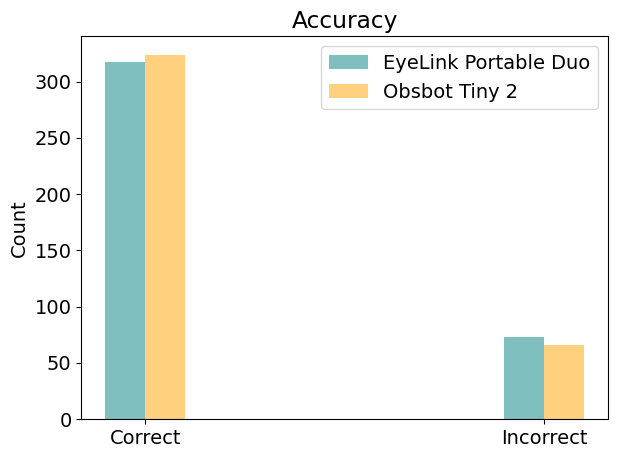

In [75]:
matplotlib.rcParams.update({'font.size':14})

# Get shared keys and their values
labels = list(asc_count.keys())
values1 = [asc_count[k] for k in labels]
values2 = [tiny_count[k] for k in labels]

x = np.arange(len(labels))  # label locations
width = 0.1  # width of bars

fig, ax = plt.subplots()
ax.bar(x - width/2, values1, width, color='teal', alpha=0.5, label='EyeLink Portable Duo')
ax.bar(x + width/2, values2, width, color='orange', alpha=0.5, label='Obsbot Tiny 2')

ax.set_ylabel('Count')
ax.set_title('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(['Correct','Incorrect'])
ax.legend()
fig.tight_layout()



In [106]:
def to_quantiles(arr):
    """
    Transform an array so each value is replaced by its quantile in the distribution.
    
    Parameters:
    arr: numpy array, input data to be transformed
    
    Returns:
    quantiles: numpy array, quantile values (between 0 and 1) corresponding to each input value
    """
    # Convert input to numpy array
    arr = np.asarray(arr)
    
    # Get ranks (using 'average' method for ties)
    ranks = np.argsort(np.argsort(arr, kind='mergesort'))  # Stable sort for consistency
    n = len(arr)
    
    # Convert ranks to quantiles: (rank + 0.5) / n for centered quantiles
    quantiles = (ranks + 0.5) / n
    
    return quantiles

In [113]:
q = to_quantiles(reaction_time_saccade_asc[:363])
# q

In [114]:
r = to_quantiles(reaction_time_saccade_tiny)
# r

In [109]:
# pd.qcut(reaction_time_saccade_asc, q=10)

In [115]:
np.corrcoef(q, r)[0, 1]

0.21670494247088912

In [48]:
np.corrcoef(reaction_time_saccade_asc, reaction_time_saccade_tiny)[0, 1]


0.8514519545430695

In [20]:
task_data_df[0]

,time,x,y,state,participant,time_delay,X,Y,interval_num,t0_ms,t_ms0,x_imputed,good_mask,x_cam_aligned,new_tinyX
0,50637492.0,959.9,654.6,1.0,P006,1.45,-0.65,0,1,50637492.0,0.0,959.9,True,1121.440714,908.804944
1,50637493.0,959.1,653.6,1.0,P006,1.45,-0.65,0,1,50637492.0,1.0,959.1,True,1121.554776,908.930772
2,50637494.0,958.0,652.9,1.0,P006,1.45,-0.65,0,1,50637492.0,2.0,958.0,True,1121.668839,909.056600
3,50637495.0,958.8,652.7,1.0,P006,1.45,-0.65,0,1,50637492.0,3.0,958.8,True,1121.782901,909.182428
4,50637496.0,960.6,655.9,1.0,P006,1.45,-0.65,0,1,50637492.0,4.0,960.6,True,1121.896963,909.308256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2264,50639756.0,1678.4,602.5,1.0,P006,1.45,-0.65,0,1,50637492.0,2264.0,1678.4,True,1701.078884,1548.233795
2265,50639757.0,1678.4,603.0,1.0,P006,1.45,-0.65,0,1,50637492.0,2265.0,1678.4,True,1701.078884,1548.233795
2266,50639758.0,1678.5,603.4,1.0,P006,1.45,-0.65,0,1,50637492.0,2266.0,1678.5,True,1701.078884,1548.233795
2267,50639759.0,1679.4,602.3,1.0,P006,1.45,-0.65,0,1,50637492.0,2267.0,1679.4,True,1701.078884,1548.233795


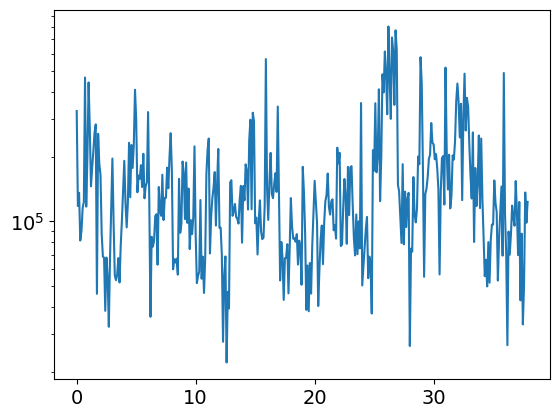

In [21]:
d_sq = []
for i in range(len(task_data_df)):
    d_sq.append(np.sum(np.abs(task_data_df[i]['new_tinyX']-task_data_df[i]['x_imputed'])))

plt.plot(np.arange(len(d_sq))/10,d_sq)
plt.yscale('log')